# Deviations from Normality

_(plus python functions with default parameters plus a quick example of recursive functions)_

Today, we'll develop the code for skewness and kurtosis even though these are already available in the `scipy.stats` module, and then we'll apply them to hedge fund index returns.

We'll also look at using `scipy.stats` module to apply the _Jarque-Bera_ test for normality, and apply them to different return series.

First, add the following code to our `edhec_risk_kit.py`

```python
def get_hfi_returns():
    """
    Load and format the EDHEC Hedge Fund Index Returns
    """
    hfi = pd.read_csv("data/edhec-hedgefundindices.csv",
                      header=0, index_col=0, parse_dates=True)
    hfi = hfi/100
    hfi.index = hfi.index.to_period('M')
    return hfi
```


In [6]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import edhec_risk_kit as erk
hfi = erk.get_hfi_returns()
hfi.head()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,Convertible Arbitrage,CTA Global,Distressed Securities,Emerging Markets,Equity Market Neutral,Event Driven,Fixed Income Arbitrage,Global Macro,Long/Short Equity,Merger Arbitrage,Relative Value,Short Selling,Funds Of Funds
date,,,,,,,,,,,,,
1997-01,0.0119,0.0393,0.0178,0.0791,0.0189,0.0213,0.0191,0.0573,0.0281,0.0150,0.0180,-0.0166,0.0317
1997-02,0.0123,0.0298,0.0122,0.0525,0.0101,0.0084,0.0122,0.0175,-0.0006,0.0034,0.0118,0.0426,0.0106
1997-03,0.0078,-0.0021,-0.0012,-0.0120,0.0016,-0.0023,0.0109,-0.0119,-0.0084,0.0060,0.0010,0.0778,-0.0077
1997-04,0.0086,-0.0170,0.0030,0.0119,0.0119,-0.0005,0.0130,0.0172,0.0084,-0.0001,0.0122,-0.0129,0.0009
1997-05,0.0156,-0.0015,0.0233,0.0315,0.0189,0.0346,0.0118,0.0108,0.0394,0.0197,0.0173,-0.0737,0.0275


## Skewness

Intuitively, a negative skew means that you get more negative returns than you would have expected if the returns were distributed like the normal distribution.

Another way of thinking about it is if that returns are normally distributed, the mean and the median would be very close.

However, if they are negatively skewed, the expected value i.e. the mean is less than the median. If they are positively skewed, the expected value (again, the mean) is greater than the median.

In [26]:
df_test = pd.concat([hfi.mean(), hfi.median(), hfi.mean()>hfi.median(), 
#                      skewness(hfi)
                    ] ,axis=1
                   )
df_test.columns = ['mean', 'median', 'mean>median', 
#                    'skewness'
                  ]
df_test

,mean,median,mean>median
Convertible Arbitrage,0.005508,0.0065,False
CTA Global,0.004074,0.0014,True
Distressed Securities,0.006946,0.0089,False
Emerging Markets,0.006253,0.0096,False
Equity Market Neutral,0.004498,0.0051,False
Event Driven,0.006344,0.0084,False
Fixed Income Arbitrage,0.004365,0.0055,False
Global Macro,0.005403,0.0038,True
Long/Short Equity,0.006331,0.0079,False
Merger Arbitrage,0.005356,0.0060,False


Now, let's develop the code to compute the skewness of a series of numbers.

Recall that the skewness is given by:

$$ S(R) = \frac{E[ (R-E(R))^3 ]}{\sigma_R^3} $$


In [8]:
def skewness(r):
    """
    Alternative to scipy.stats.skew()
    Computes the skewness of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3


In [32]:
skewness(hfi).sort_values()

Fixed Income Arbitrage   -3.940320
Convertible Arbitrage    -2.639592
Equity Market Neutral    -2.124435
Relative Value           -1.815470
Event Driven             -1.409154
Merger Arbitrage         -1.320083
Distressed Securities    -1.300842
Emerging Markets         -1.167067
Long/Short Equity        -0.390227
Funds Of Funds           -0.361783
CTA Global                0.173699
Short Selling             0.767975
Global Macro              0.982922
dtype: float64

Just to see if we get the same answer, let's use the skewness function that is built into `scipy.stats`

In [5]:
import scipy.stats
scipy.stats.skew(hfi)

array([-2.63959223,  0.17369864, -1.30084204, -1.16706749, -2.12443538,
       -1.40915356, -3.94032029,  0.98292188, -0.39022677, -1.32008333,
       -1.81546975,  0.76797484, -0.36178308])

So, let's add that to our `edhec_risk_kit.py`.

Finally, let's look at the skewness that you would expect from a truly random sequence of returns. Let's use the random normal generator from numpy and generate the same number of returns as we have for the hedge fund data.

In [33]:
hfi.shape

(263, 13)

In [34]:
import numpy as np
normal_rets = np.random.normal(0, 0.15, (263, 1))

In [35]:
normal_rets.mean(), normal_rets.std()

(-0.008408595738808372, 0.15490230511359246)

In [37]:
erk.skewness(normal_rets)

-0.008092605872066543

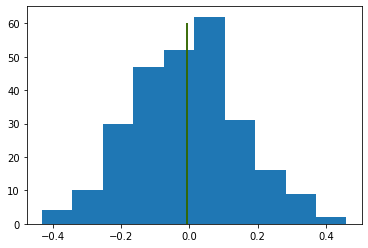

In [48]:
import matplotlib.pyplot as plt
plt.hist(normal_rets)
plt.vlines([normal_rets.mean(), np.median(normal_rets)], 0, 60, colors=['red', 'green'])

# Kurtosis

Intuitively, the kurtosis measures the "fatness" of the tails of the distribution. The normal distribution has a kurtosis of 3 and so if the kurtosis of your returns is less than 3 then it tends to have thinner tails, and if the kurtosis is greater than 3 then the distribution has fatter tails.

Kurtosis is given by:

$$ K(R) = \frac{E[ (R-E(R))^4 ]}{\sigma_R^4} $$

This is very similar to the skewness, so we can just copy and paste it and then edit it to compute the 4th rather than the 3rd power (as was the case for skewness).


In [49]:
erk.kurtosis(hfi)

Convertible Arbitrage     23.280834
CTA Global                 2.952960
Distressed Securities      7.889983
Emerging Markets           9.250788
Equity Market Neutral     17.218555
Event Driven               8.035828
Fixed Income Arbitrage    29.842199
Global Macro               5.741679
Long/Short Equity          4.523893
Merger Arbitrage           8.738950
Relative Value            12.121208
Short Selling              6.117772
Funds Of Funds             7.070153
dtype: float64

Let's compare it with `scipy.stats` ...

In [51]:
import scipy
scipy.stats.kurtosis(hfi)

array([20.28083446, -0.04703963,  4.88998336,  6.25078841, 14.21855526,
        5.03582817, 26.84219928,  2.74167945,  1.52389258,  5.73894979,
        9.12120787,  3.11777175,  4.07015278])

Note that these numbers are all lower by 3 from the number we have computed. That's because, as we said above, the expected kurtosis of a normally distributed series of numbers is 3, and `scipy.stats` is returning the _Excess Kurtosis_. We can see this by applying it on the random normal numbers we generated:

In [12]:
scipy.stats.kurtosis(normal_rets)

array([-0.04077066])

In [13]:
erk.kurtosis(normal_rets)

2.959229340906525

## Running the Jarque-Bera Test for Normality

The `scipy.stats` module contains a function that runs the _Jarque-Bera_ test on a sequence of numbers. Let's apply that to the normally generated returns:

In [52]:
scipy.stats.jarque_bera(normal_rets)

(0.023612379781461017, 0.9882632297069173)

The first number is the test statistic and the second number is the one we want. It represents the p-value for the hypothesis test. If you want to run the test at a 1% level of significance, you want this number to be greater than 0.01 to accept the hypothesis that the data is normally distributed, and if that number is less than 0.01 then you must reject the hypothesis of normality.

In this case, since we got a number higher than 0.01 we can accept the hypothesis that the numbers are random. Now, let's try this on our different hedge fund indices.

In [53]:
scipy.stats.jarque_bera(hfi)

(25656.585999171326, 0.0)

Why didn't we get the results for the individual indices? Because the implementation of the test isn't smart enough to realize that we want to treat each column as a separate set of returns. We can write out own wrapper for it to fix that, so let's start by writing a simple wrapper, and adding this code to our python file:

```python
import scipy.stats
def is_normal(r, level=0.01):
    """
    Applies the Jarque-Bera test to determine if a Series is normal or not
    Test is applied at the 1% level by default
    Returns True if the hypothesis of normality is accepted, False otherwise
    """
    statistic, p_value = scipy.stats.jarque_bera(r)
    return p_value > level
```

In [54]:
erk.is_normal(normal_rets)

True

There are a few different ways to handle the problem. The first is to use the `.aggregate` method on a dataframe, that takes a function as an argument and applies that function to each column:

In [55]:
hfi.aggregate(erk.is_normal)

Convertible Arbitrage     False
CTA Global                 True
Distressed Securities     False
Emerging Markets          False
Equity Market Neutral     False
Event Driven              False
Fixed Income Arbitrage    False
Global Macro              False
Long/Short Equity         False
Merger Arbitrage          False
Relative Value            False
Short Selling             False
Funds Of Funds            False
dtype: bool

However, we can fix this in our wrapper so that we have a uniform interface to test normality:

```python
import scipy.stats
def is_normal(r, level=0.01):
    """
    Applies the Jarque-Bera test to determine if a Series is normal or not
    Test is applied at the 1% level by default
    Returns True if the hypothesis of normality is accepted, False otherwise
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(is_normal)
    else:
        statistic, p_value = scipy.stats.jarque_bera(r)
        return p_value > level
```


In [59]:
import pandas as pd
isinstance(hfi, pd.DataFrame)

True

In [60]:
erk.is_normal(normal_rets)

True

In [61]:
erk.is_normal(hfi)

Convertible Arbitrage     False
CTA Global                 True
Distressed Securities     False
Emerging Markets          False
Equity Market Neutral     False
Event Driven              False
Fixed Income Arbitrage    False
Global Macro              False
Long/Short Equity         False
Merger Arbitrage          False
Relative Value            False
Short Selling             False
Funds Of Funds            False
dtype: bool

## Testing CRSP SmallCap and Large Cap returns for Normality

Let's see whether any of the returns we've been studying so far pass the normality hypothesis.

In [62]:
ffme = erk.get_ffme_returns()
erk.skewness(ffme)

SmallCap    4.410739
LargeCap    0.233445
dtype: float64

In [21]:
erk.kurtosis(ffme)

SmallCap    46.845008
LargeCap    10.694654
dtype: float64

In [22]:
erk.is_normal(ffme)

SmallCap    False
LargeCap    False
dtype: bool